<a href="https://colab.research.google.com/github/pedroivobr/amazon_reviews/blob/main/amazon_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
## baixando dataset
import opendatasets as od

od.download('https://www.kaggle.com/kritanjalijain/amazon-reviews')

  0%|          | 5.00M/1.29G [00:00<00:29, 47.6MB/s]

100%|██████████| 1.29G/1.29G [00:10<00:00, 135MB/s]


In [ ]:
## extraindo arquivos
import tarfile

amazon_reviews_zip = tarfile.open('amazon-reviews/amazon_review_polarity_csv.tgz')
amazon_reviews_zip.extractall('dados')
amazon_reviews_zip.close()

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix #Exposição das estatísticas
from string import punctuation
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
## lendo arquivos
df_test = pd.read_csv('dados/amazon_review_polarity_csv/test.csv', sep=',',quotechar='"', header=None, names=['class','title','description'])
df_train = pd.read_csv('dados/amazon_review_polarity_csv/train.csv',sep=',',quotechar='"', header=None, names=['class','title','description'])

In [ ]:
## unindo arquivos de teste e treino
reviews = pd.concat([df_test,df_train], axis=0)
reviews.shape

(4000000, 3)

In [ ]:
reviews.sample(5)

,class,title,description
2126723,2,Good for Bible Reading Enjoyment,"while this version should not be used for ""stu..."
745987,1,What a disappointment,"i hate to give anyone a bad review, but the be..."
1567222,1,with I hadn't bought this machine.,the blades wear out quickly can't be sharpened...
2132255,1,Stay away from this product,very bad product as others have said. we've ha...
3344884,2,Great Bimini Album,a great album by bimini's piccolo pete. terrif...


In [ ]:
## verificando se tem alguma review nula
reviews.isna().sum()

class           0
title          87
description     0
dtype: int64

In [ ]:
## colocando toda a review em minusculo 
reviews.description = reviews.description.str.lower()

In [ ]:
## pegando uma pequena amostrar dos 4M de linhas
reviews_test = reviews.sample(50000)

In [ ]:
## resetando index
reviews_test.reset_index(drop=True, inplace=True)

In [ ]:
## tokenize
reviews_test['tokenize'] = [word_tokenize(entry) for entry in reviews_test.description]

In [ ]:
reviews_test

,class,title,description,tokenize
0,2,The Philistines DVD was informative,after watching the video i have a much better ...,"[after, watching, the, video, i, have, a, much..."
1,1,Poor support,don't try getting repair parts from swisher. y...,"[do, n't, try, getting, repair, parts, from, s..."
2,1,Complete Disappointment,complete worthless waste of time and money. i ...,"[complete, worthless, waste, of, time, and, mo..."
3,2,Tonight's the Night - Neil Young,great album by neil young. what else would you...,"[great, album, by, neil, young, ., what, else,..."
4,2,Some of the most romantic Argentine Tango musi...,if you have so far associated argentine tango ...,"[if, you, have, so, far, associated, argentine..."
...,...,...,...,...
49995,1,"Very, very disappointed","try recipes: orange cake, chocolate chip cooki...","[try, recipes, :, orange, cake, ,, chocolate, ..."
49996,2,squirrel proof birdfeeder,very nice bird feeder. not quite squirrel-proo...,"[very, nice, bird, feeder, ., not, quite, squi..."
49997,1,Weak plastic case.,this is a fabulous device but unfortunately ha...,"[this, is, a, fabulous, device, but, unfortuna..."
49998,1,lasted a month,this worked great but only lasted a month.... ...,"[this, worked, great, but, only, lasted, a, mo..."


In [ ]:
from nltk.corpus import stopwords

## definindo stopwords
stopwords = set(stopwords.words('english') + list(punctuation))

In [ ]:
## flat_list para criar uma nuvem de palavras
flat_list = [word for sentence in reviews_test['tokenize'] for word in sentence if word not in stopwords and word.isalpha()]

In [ ]:
## concatenando todas as palavras da lista separadas por espaço
todas_palavras = " ".join(flat_list)

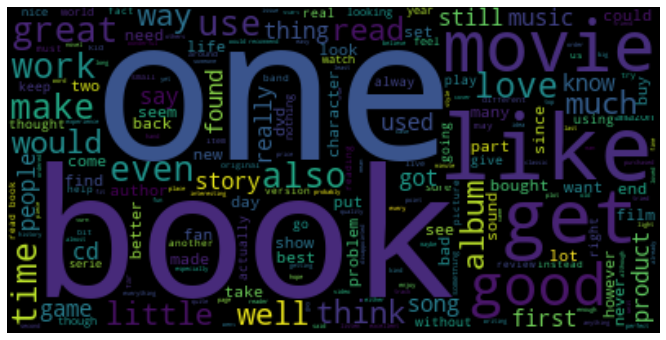

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# gerar uma wordcloud
wordcloud = WordCloud(stopwords=stopwords).generate(todas_palavras)
# mostrar a imagem final
fig, ax = plt.subplots(figsize=(20,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

In [ ]:
## WordNetLemmatizer requer POS TAGS para entedender se a palavra é um substantito, verbo, adjetivo ou etc. Por padrão é definido como substantivo.
## https://pythonexamples.org/nltk-pos-tagging/
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV
for index,entry in enumerate(reviews_test['tokenize']):
    ## Lista com as palavras finais pós processo de lemma
    Final_words = []
    ## Inicializando WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    ## A função pos_tag fornece a tag da palavra, por exemplo se ela é Verbo ou Adjetivo.
    for word, tag in pos_tag(entry):
        ## Removendo as stopswords e caracteres não letras ( números, pontuação ... )
        if word not in stopwords and word.isalpha():
          ## lemmatize (palavra, classe gramatical)
          word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
          Final_words.append(word_Final)
    ## A lista final pós-processamento da interação
    reviews_test.loc[index,'text_final'] = str(Final_words)

In [ ]:
## separando em dados de treinamento e teste
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(reviews_test['text_final'],reviews_test['class'],test_size=0.4)

In [ ]:
Encoder = LabelEncoder()

## retorna as etiquetas codificadas
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

In [ ]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(reviews_test['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [ ]:
## Classificador - Naive Bayes
## ajuste no conjunto de treinamento do Naive Bayes
Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf,Train_Y)
## predição com os dados de teste
predictions_NB = Naive.predict(Test_X_Tfidf)
## Usando accuracy_score para obter a acuracia
print("Naive Bayes Accuracy Score -> ",accuracy_score(predictions_NB, Test_Y)*100)

Naive Bayes Accuracy Score ->  80.585


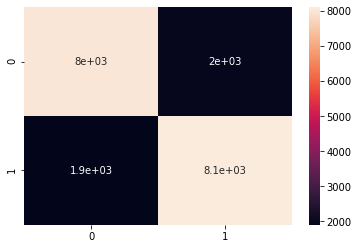

In [ ]:
sns.heatmap(confusion_matrix(Test_Y,predictions_NB),annot=True)

In [ ]:
## Classificador - SVM
## ajuste no conjunto de treinamento do SVM
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
## predição com os dados de teste
predictions_SVM = SVM.predict(Test_X_Tfidf)
## Usando accuracy_score para obter a acuracia
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  83.96000000000001


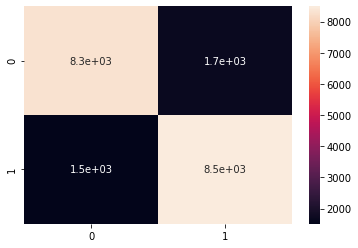

In [ ]:
sns.heatmap(confusion_matrix(Test_Y,predictions_SVM),annot=True)